# 1. Introduction to Libraries

In this notebook, we will build a CNN‐LSTM hybrid model in PyTorch to predict hourly energy consumption in the ComEd region (Illinois), using weather data from multiple stations.  
Below, we list and briefly explain each library we use.

- **numpy**: Fundamental package for array computing.
- **pandas**: DataFrame structures and I/O (reading CSV, handling dates).
- **matplotlib** & **seaborn**: Plotting and visualization.
- **scikit‐learn**: Data splitting, metrics (RMSE, MAPE), and TimeSeriesSplit.
- **torch** (PyTorch): Model definition, tensors, training loops.
- **torch.nn** and **torch.optim**: Neural network layers, loss functions, optimizers.
- **tqdm**: Progress bars.


In [3]:
# Importing Libraries
# Core data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,  HistGradientBoostingRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Utilities
from tqdm.notebook import tqdm
import copy

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
plt.style.use('seaborn-v0_8-whitegrid')

# 2. Data Loading & Preprocessing

Load the Data and preprocess it.
We are checking the shape of the data, the features and objects.

In [4]:
weather_energy_df = pd.read_csv('merged_energy_weather.csv', sep=",")

In [5]:
weather_energy_df.shape

(66498, 95)

In [6]:
weather_energy_df.head(5)

,Unnamed: 0,COMED_MW,temp_AUR,temp_BC,temp_DKC,temp_FRE,temp_KAN,temp_LYN,temp_MDW,temp_ORD,...,prcp_ORD_prcp_WOG_merged,prcp_RFD_prcp_ROC_merged,wdir_JOL_wdir_JRA_merged,wdir_SRA_wdir_SWD_merged,wspd_JOL_wspd_JRA_merged,wspd_SRA_wspd_SWD_merged,pres_AUR_pres_DKC_merged,pres_JOL_pres_LYN_merged,pres_RFD_pres_ROC_merged,pres_SRA_pres_SWD_merged
0,2011-01-01 07:00:00+00:00,9631.0,3.3,5.0,3.3,0.247652,7.693101,6.1,6.1,4.4,...,0.0,0.0,260.0,250.0,25.9,18.4,1007.9,1007.2,1007.7,1007.1
1,2011-01-01 08:00:00+00:00,9273.0,2.2,3.9,2.2,-0.080259,5.509144,4.4,4.4,2.8,...,0.0,0.0,260.0,230.0,22.3,20.5,1008.2,1007.9,1008.3,1007.6
2,2011-01-01 09:00:00+00:00,9011.0,0.6,2.8,0.6,-2.542620,3.487656,3.3,3.3,2.2,...,0.0,0.0,250.0,220.0,18.4,33.5,1008.7,1008.2,1009.0,1007.9
3,2011-01-01 10:00:00+00:00,8741.0,-0.6,0.6,-0.6,-3.816004,2.504727,2.2,2.2,0.0,...,0.0,0.0,230.0,230.0,22.3,29.5,1008.8,1008.4,1008.5,1008.1
4,2011-01-01 11:00:00+00:00,8694.0,-2.2,-0.6,-2.2,-5.277747,0.859336,0.6,0.6,-0.6,...,0.0,0.0,240.0,230.0,27.7,29.5,1009.3,1008.8,1009.4,1008.6


In [7]:
weather_energy_df.rename(columns={'Unnamed: 0': 'time'}, inplace=True)

In [8]:
weather_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66498 entries, 0 to 66497
Data columns (total 95 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   time                      66498 non-null  object 
 1   COMED_MW                  66498 non-null  float64
 2   temp_AUR                  66498 non-null  float64
 3   temp_BC                   66498 non-null  float64
 4   temp_DKC                  66498 non-null  float64
 5   temp_FRE                  66498 non-null  float64
 6   temp_KAN                  66498 non-null  float64
 7   temp_LYN                  66498 non-null  float64
 8   temp_MDW                  66498 non-null  float64
 9   temp_ORD                  66498 non-null  float64
 10  temp_PON                  66498 non-null  float64
 11  temp_RFD                  66498 non-null  float64
 12  temp_ROC                  66498 non-null  float64
 13  temp_SAR                  66498 non-null  float64
 14  temp_S

In [9]:
weather_energy_df.describe()

,COMED_MW,temp_AUR,temp_BC,temp_DKC,temp_FRE,temp_KAN,temp_LYN,temp_MDW,temp_ORD,temp_PON,...,prcp_ORD_prcp_WOG_merged,prcp_RFD_prcp_ROC_merged,wdir_JOL_wdir_JRA_merged,wdir_SRA_wdir_SWD_merged,wspd_JOL_wspd_JRA_merged,wspd_SRA_wspd_SWD_merged,pres_AUR_pres_DKC_merged,pres_JOL_pres_LYN_merged,pres_RFD_pres_ROC_merged,pres_SRA_pres_SWD_merged
count,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,...,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000,66498.000000
mean,11419.711352,9.987159,9.183387,9.473248,9.113843,10.781478,10.340808,11.435335,10.642580,11.424936,...,0.110739,0.139091,195.093000,194.296078,14.813942,14.383538,1016.796187,1016.612928,1017.111264,1016.499409
std,2303.960315,11.887654,11.255948,11.764514,11.776318,11.547803,11.330039,11.561444,11.599715,11.675575,...,0.700269,0.852088,96.518254,98.660735,9.095943,9.004639,7.540450,7.704365,7.638260,7.506443
min,7237.000000,-30.000000,-26.700000,-28.300000,-27.300000,-29.300000,-26.200000,-25.600000,-26.700000,-29.500000,...,0.000000,-0.379252,10.000000,7.000000,0.000000,0.000000,982.900000,983.200000,984.700000,982.600000
25%,9780.000000,1.100000,1.100000,0.500000,0.300000,1.700000,1.500000,2.200000,1.700000,2.000000,...,0.000000,0.000000,120.000000,120.000000,9.400000,7.600000,1012.100000,1011.700000,1012.300000,1011.900000
50%,11151.000000,10.600000,9.400000,10.100000,9.600000,11.393239,10.600000,11.700000,11.100000,12.000000,...,0.000000,0.000000,200.000000,200.000000,13.000000,13.000000,1016.500000,1016.200000,1016.800000,1016.300000
75%,12510.000000,20.000000,18.300000,19.200000,18.600000,20.200000,19.800000,21.100000,20.600000,21.000000,...,0.000000,0.000000,270.000000,275.000000,20.500000,20.500000,1021.500000,1021.400000,1021.900000,1021.200000
max,23753.000000,38.300000,38.900000,37.600000,36.700000,38.000000,39.000000,39.400000,39.400000,39.000000,...,38.850000,36.800000,370.043122,360.000000,70.600000,61.200000,1044.800000,1044.800000,1045.200000,1043.900000


# 3. Feature Engineering

Here we are engineering new features from our time column.
We are getting **hour**, **isweekend**, **day_of_week** and **month**.

In [10]:
# Convert the "time" column into a true datetime type - format="%Y-%m-%d %H:%M:%S"
weather_energy_df["time"] = pd.to_datetime(weather_energy_df["time"], errors='raise')

# Set "time" as the index and sort by it (just in case)
weather_energy_df = weather_energy_df.set_index("time").sort_index()

# Verify the changes
print(weather_energy_df.index.min(), weather_energy_df.index.max())
print(weather_energy_df.index.freq)

2011-01-01 07:00:00+00:00 2018-08-03 00:00:00+00:00
None


In [11]:
# Feature Engineering: Extract hour‐of‐day, day‐of‐week, and month as new columns
weather_energy_df["hour"] = weather_energy_df.index.hour
weather_energy_df["day_of_week"] = weather_energy_df.index.dayofweek # we are starting from 0, 0 -Monday, 6-Sunday
weather_energy_df["month"] = weather_energy_df.index.month

# “weekend vs. weekday” as a boolean:
weather_energy_df["is_weekend"] = weather_energy_df["day_of_week"].isin([5, 6]).astype(int)

# View the first few rows to confirm
weather_energy_df[["hour", "day_of_week", "month", "is_weekend"]].head(5)


,hour,day_of_week,month,is_weekend
time,,,,
2011-01-01 07:00:00+00:00,7,5,1,1
2011-01-01 08:00:00+00:00,8,5,1,1
2011-01-01 09:00:00+00:00,9,5,1,1
2011-01-01 10:00:00+00:00,10,5,1,1
2011-01-01 11:00:00+00:00,11,5,1,1


In [12]:
weather_energy_df.shape

(66498, 98)

In [13]:
weather_energy_df.head(5)

,COMED_MW,temp_AUR,temp_BC,temp_DKC,temp_FRE,temp_KAN,temp_LYN,temp_MDW,temp_ORD,temp_PON,...,wspd_JOL_wspd_JRA_merged,wspd_SRA_wspd_SWD_merged,pres_AUR_pres_DKC_merged,pres_JOL_pres_LYN_merged,pres_RFD_pres_ROC_merged,pres_SRA_pres_SWD_merged,hour,day_of_week,month,is_weekend
time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 07:00:00+00:00,9631.0,3.3,5.0,3.3,0.247652,7.693101,6.1,6.1,4.4,7.747203,...,25.9,18.4,1007.9,1007.2,1007.7,1007.1,7,5,1,1
2011-01-01 08:00:00+00:00,9273.0,2.2,3.9,2.2,-0.080259,5.509144,4.4,4.4,2.8,5.497401,...,22.3,20.5,1008.2,1007.9,1008.3,1007.6,8,5,1,1
2011-01-01 09:00:00+00:00,9011.0,0.6,2.8,0.6,-2.542620,3.487656,3.3,3.3,2.2,3.186248,...,18.4,33.5,1008.7,1008.2,1009.0,1007.9,9,5,1,1
2011-01-01 10:00:00+00:00,8741.0,-0.6,0.6,-0.6,-3.816004,2.504727,2.2,2.2,0.0,1.946568,...,22.3,29.5,1008.8,1008.4,1008.5,1008.1,10,5,1,1
2011-01-01 11:00:00+00:00,8694.0,-2.2,-0.6,-2.2,-5.277747,0.859336,0.6,0.6,-0.6,0.802695,...,27.7,29.5,1009.3,1008.8,1009.4,1008.6,11,5,1,1


# 3. Identify and Seperate Target Column from the other Features.

Our tagret Column is 'COMED_MW.
The other columns are our feature columns.

In [14]:
# Target Column or Feature
TARGET_COL = 'COMED_MW'

In [15]:
all_other_columns = [col for col in weather_energy_df.columns if col != TARGET_COL]

# Create the final list, ensuring 'COMED_MW' our Target Column is the first column.
feature_columns = [TARGET_COL] + all_other_columns
features_df = weather_energy_df[feature_columns].copy()

print(f"Using all {len(features_df.columns)} columns as features for the model.")
features_df.head()

Using all 98 columns as features for the model.


,COMED_MW,temp_AUR,temp_BC,temp_DKC,temp_FRE,temp_KAN,temp_LYN,temp_MDW,temp_ORD,temp_PON,...,wspd_JOL_wspd_JRA_merged,wspd_SRA_wspd_SWD_merged,pres_AUR_pres_DKC_merged,pres_JOL_pres_LYN_merged,pres_RFD_pres_ROC_merged,pres_SRA_pres_SWD_merged,hour,day_of_week,month,is_weekend
time,,,,,,,,,,,,,,,,,,,,,
2011-01-01 07:00:00+00:00,9631.0,3.3,5.0,3.3,0.247652,7.693101,6.1,6.1,4.4,7.747203,...,25.9,18.4,1007.9,1007.2,1007.7,1007.1,7,5,1,1
2011-01-01 08:00:00+00:00,9273.0,2.2,3.9,2.2,-0.080259,5.509144,4.4,4.4,2.8,5.497401,...,22.3,20.5,1008.2,1007.9,1008.3,1007.6,8,5,1,1
2011-01-01 09:00:00+00:00,9011.0,0.6,2.8,0.6,-2.542620,3.487656,3.3,3.3,2.2,3.186248,...,18.4,33.5,1008.7,1008.2,1009.0,1007.9,9,5,1,1
2011-01-01 10:00:00+00:00,8741.0,-0.6,0.6,-0.6,-3.816004,2.504727,2.2,2.2,0.0,1.946568,...,22.3,29.5,1008.8,1008.4,1008.5,1008.1,10,5,1,1
2011-01-01 11:00:00+00:00,8694.0,-2.2,-0.6,-2.2,-5.277747,0.859336,0.6,0.6,-0.6,0.802695,...,27.7,29.5,1009.3,1008.8,1009.4,1008.6,11,5,1,1


## 4 Data Splitting and Scaling  

- For our time series data, we cannot shuffle and split the data randomly.
-  We split the data chronologically into a training set (the first 70%), a validation set (the next 15%), and a test set (the final 15%).


In [25]:
train_size = int(len(features_df) * 0.70)
val_size = int(len(features_df) * 0.15)
test_size = len(features_df) - train_size - val_size

train_df = features_df.iloc[:train_size]
val_df = features_df.iloc[train_size:train_size + val_size]
test_df = features_df.iloc[train_size + val_size:]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 46548
Validation set size: 9974
Test set size: 9976


In [26]:
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent data leakage.
train_scaled = scaler.fit_transform(train_df)
# Then, use the already-fitted scaler to transform the other two sets.
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

# 5. Create Sliding Windows

Convert the time series into supervised samples:
- **X**: past 24 hours of features  
- **y**: next‐hour load  


In [27]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x = data[i:i + n_steps, :]
        seq_y = data[i + n_steps, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 24

X_train, y_train = create_sequences(train_scaled, n_steps)
X_val, y_val = create_sequences(val_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

In [28]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float().view(-1, 1)
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float().view(-1, 1)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float().view(-1, 1)

# 9. Define the CNN–LSTM Hybrid Model

Architecture:
1. Two 1D-Conv blocks (over the 24-hour window) to learn local temporal patterns  
2. LSTM to capture longer dependencies  
3. Fully connected layer to output next-hour load  


In [29]:
class CNNLSTM(nn.Module):
    def __init__(self, n_features, cnn_filters=128, lstm_units=128, dropout=0.3):
        super(CNNLSTM, self).__init__()

        self.conv1d = nn.Conv1d(in_channels=n_features,
                                out_channels=cnn_filters,
                                kernel_size=2,
                                padding='same')
        self.relu = nn.ReLU()

        self.lstm = nn.LSTM(input_size=cnn_filters,
                            hidden_size=lstm_units,
                            num_layers=3,
                            batch_first=True,
                            dropout=dropout)

        self.fc = nn.Linear(in_features=lstm_units, out_features=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)

        _, (h_n, _) = self.lstm(x)
        last_hidden_state = h_n[-1]

        out = self.fc(last_hidden_state)
        return out

Model Training and Validation

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 20

n_features = X_train.shape[2]
model = CNNLSTM(n_features=n_features).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [31]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
print("\n--- Starting Training ---")
best_val_loss = float('inf')
early_stopping_patience = 5
early_stopping_counter = 0

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("   -> Validation loss decreased. Saving model.")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"   -> Validation loss did not improve. Counter: {early_stopping_counter}/{early_stopping_patience}")

    if early_stopping_counter >= early_stopping_patience:
        print("--- Early stopping triggered. ---")
        break

print("--- Training Complete ---")


--- Starting Training ---
Epoch 1/20, Train Loss: 0.255798, Val Loss: 0.367118
   -> Validation loss decreased. Saving model.
Epoch 2/20, Train Loss: 0.052665, Val Loss: 0.084536
   -> Validation loss decreased. Saving model.
Epoch 3/20, Train Loss: 0.029661, Val Loss: 0.142030
   -> Validation loss did not improve. Counter: 1/5
Epoch 4/20, Train Loss: 0.028182, Val Loss: 0.120408
   -> Validation loss did not improve. Counter: 2/5
Epoch 5/20, Train Loss: 0.027381, Val Loss: 0.136582
   -> Validation loss did not improve. Counter: 3/5
Epoch 6/20, Train Loss: 0.020966, Val Loss: 0.123894
   -> Validation loss did not improve. Counter: 4/5
Epoch 7/20, Train Loss: 0.016885, Val Loss: 0.031605
   -> Validation loss decreased. Saving model.
Epoch 8/20, Train Loss: 0.011773, Val Loss: 0.024081
   -> Validation loss decreased. Saving model.
Epoch 9/20, Train Loss: 0.009937, Val Loss: 0.019701
   -> Validation loss decreased. Saving model.
Epoch 10/20, Train Loss: 0.010890, Val Loss: 0.022710

Final Evaluation and Visualization

In [33]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    test_predictions = model(X_test.to(device))

test_predictions = test_predictions.cpu()

In [34]:
# Create a dummy array to match the shape the scaler expects
dummy_preds = np.zeros((len(test_predictions), n_features))
dummy_preds[:, 0] = test_predictions.numpy().flatten()
predictions_mw = scaler.inverse_transform(dummy_preds)[:, 0]

dummy_actual = np.zeros((len(y_test), n_features))
dummy_actual[:, 0] = y_test.numpy().flatten()
actuals_mw = scaler.inverse_transform(dummy_actual)[:, 0]

In [35]:
rmse = np.sqrt(mean_squared_error(actuals_mw, predictions_mw))
mape = mean_absolute_percentage_error(actuals_mw, predictions_mw)

print("\n--- Final Evaluation on Test Set ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")


--- Final Evaluation on Test Set ---
Root Mean Squared Error (RMSE): 205.76 MW
Mean Absolute Percentage Error (MAPE): 1.40%


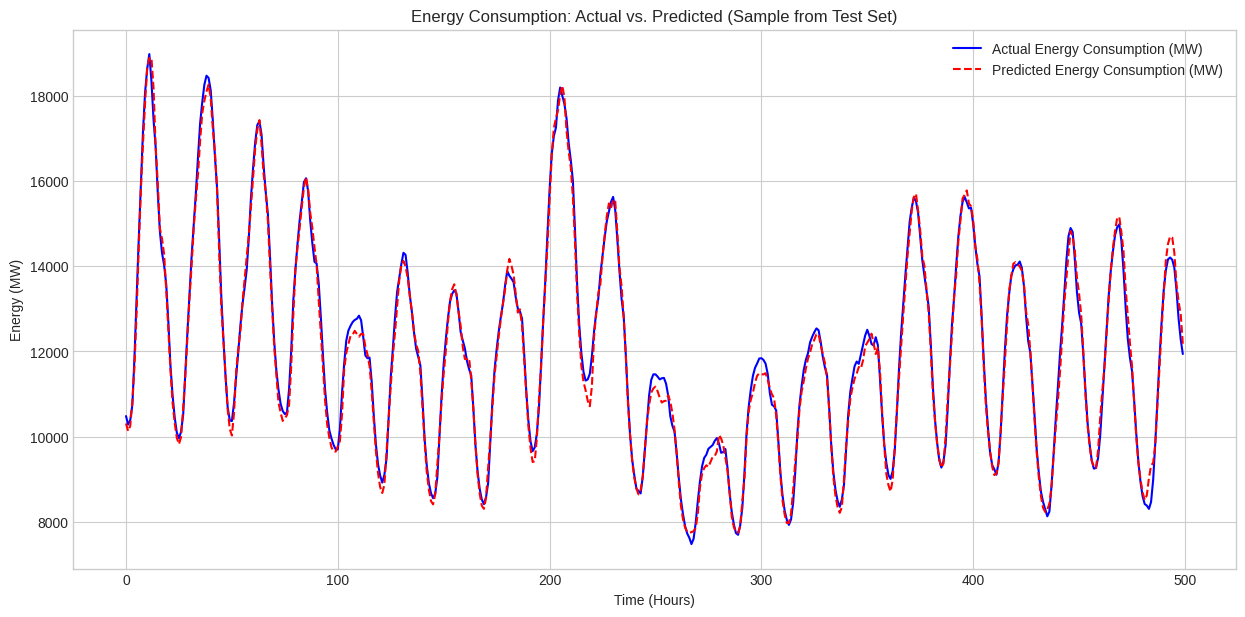

In [38]:
plt.figure(figsize=(15, 7))
plt.plot(actuals_mw[:500], label='Actual Energy Consumption (MW)', color='blue')
plt.plot(predictions_mw[:500], label='Predicted Energy Consumption (MW)', color='red', linestyle='--')
plt.title('Energy Consumption: Actual vs. Predicted (Sample from Test Set)')
plt.xlabel('Time (Hours)')
plt.ylabel('Energy (MW)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Create aggregate weather features from the original DataFrame
temp_cols = [col for col in weather_energy_df.columns if 'temp' in col]
prcp_cols = [col for col in weather_energy_df.columns if 'prcp' in col]
weather_energy_df['avg_temp'] = weather_energy_df[temp_cols].mean(axis=1)
weather_energy_df['total_prcp'] = weather_energy_df[prcp_cols].sum(axis=1)

In [50]:
hot_threshold = weather_energy_df['avg_temp'].quantile(0.90)  # Top 10% hottest hours
cold_threshold = weather_energy_df['avg_temp'].quantile(0.10) # Bottom 10% coldest hours
mild_low = weather_energy_df['avg_temp'].quantile(0.40)       # 40th percentile
mild_high = weather_energy_df['avg_temp'].quantile(0.60)      # 60th percentile

# Filter data for each condition
hot_sunny_days = weather_energy_df[(weather_energy_df['avg_temp'] >= hot_threshold) & (weather_energy_df['total_prcp'] == 0)]
cold_days = weather_energy_df[weather_energy_df['avg_temp'] <= cold_threshold]
rainy_days = weather_energy_df[weather_energy_df['total_prcp'] > 0]
mild_clear_days = weather_energy_df[(weather_energy_df['avg_temp'] > mild_low) & (weather_energy_df['avg_temp'] < mild_high) & (weather_energy_df['total_prcp'] == 0)]

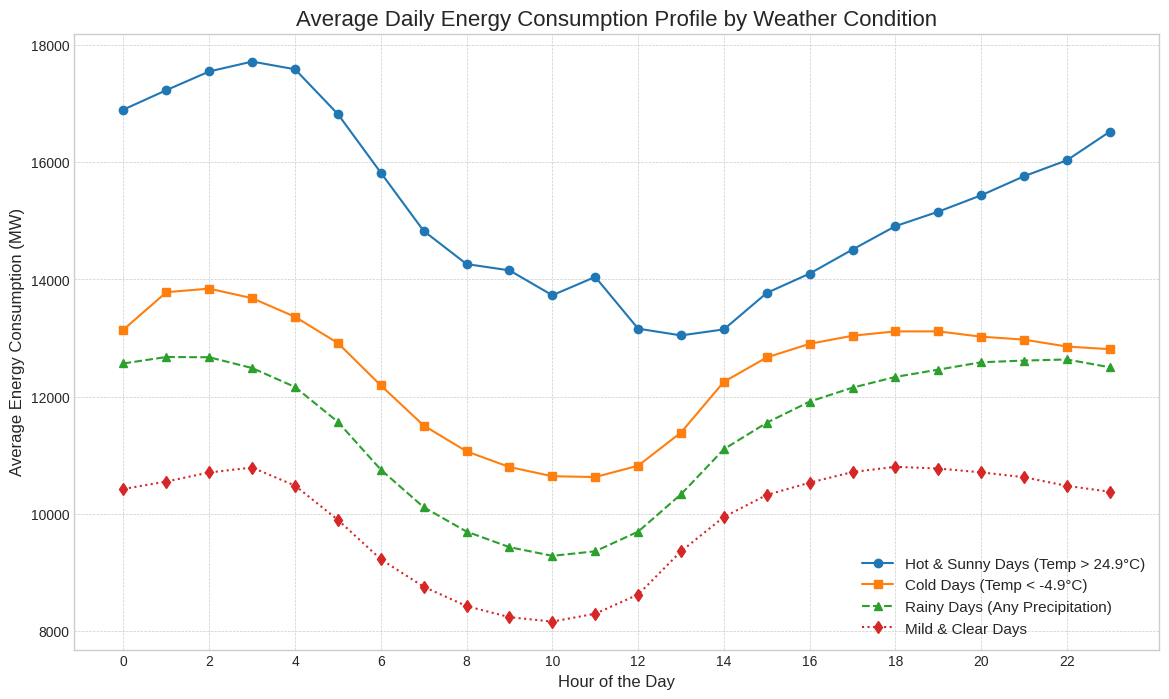

In [51]:
# Calculate the average consumption profile for each condition
hot_profile = hot_sunny_days.groupby('hour')['COMED_MW'].mean()
cold_profile = cold_days.groupby('hour')['COMED_MW'].mean()
rainy_profile = rainy_days.groupby('hour')['COMED_MW'].mean()
mild_profile = mild_clear_days.groupby('hour')['COMED_MW'].mean()

# --- Plotting the Comparison ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(14, 8))

# Plot each profile with a distinct style for clarity
hot_profile.plot(label=f'Hot & Sunny Days (Temp > {hot_threshold:.1f}°C)', marker='o', linestyle='-')
cold_profile.plot(label=f'Cold Days (Temp < {cold_threshold:.1f}°C)', marker='s', linestyle='-')
rainy_profile.plot(label='Rainy Days (Any Precipitation)', marker='^', linestyle='--')
mild_profile.plot(label='Mild & Clear Days', marker='d', linestyle=':')

# Add labels, title, legend, and grid for better readability
plt.title('Average Daily Energy Consumption Profile by Weather Condition', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average Energy Consumption (MW)', fontsize=12)
plt.xticks(np.arange(0, 24, 2))
plt.legend(fontsize=11)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()